# GEM2 Data Modelling: In-phase and Quadrature components

To run this notebook you need to install `empymod` and `matplotlib`.
For the documentation of `empymod` see [empymod.emsig.xyz](https://empymod.emsig.xyz).

Installation: You can install it in the usual manner from PyPI or conda:

```
conda install -c conda-forge empymod matplotlib
```
or
```
pip install empymod matplotlib
```

Reference:
> Werthmüller, D., 2017,  
> An open-source full 3D electromagnetic modeler for 1D VTI media in Python: empymod:  
> Geophysics, 82(6), WB9-WB19; DOI: 10.1190/geo2016-0626.1; [empymod.emsig.xyz](https://empymod.emsig.xyz)

In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

### In-phase and Quadrature modelling routine

- `empymod` has an in-phase and quadrature modelling routine, `empymod.ip_and_q`; see https://empymod.emsig.xyz/en/stable/api/empymod.model.ip_and_q.html for more information.
- There is an example in the gallery of the routine, see https://empymod.emsig.xyz/en/stable/gallery/fdomain/ipandq.html.

#### Important
To use `empymod.ip_and_q`, you need **empymod >= v2.5.0**. If you have an earlier version, you can copy the relevant code from https://github.com/emsig/empymod/blob/main/empymod/model.py#L1770-L1830

### Orientation of loops

The GEM2 works either in horizontal co-planar (HCP) or vertical co-planar (VCP) mode. However, synthetically we can of course model any combination we like.


#### `ab`-Parameter

`empymod.dipole` can model x-, y-, and z-directed, infinitesimal small electric and magnetic dipoles. The directions are defined in the parameter `ab`, which consists of two digits from 1-6; the first digit defines the orientation of the receiver (`a`) and the second digit the orientation of the source (`b`). An x-directed, magnetic source measured by a z-directed, magnetic receiver has therefore `ab=64`. The combination for magnetic sources and receivers are (see https://empymod.emsig.xyz/en/stable/api/empymod.model.dipole.html for all possibilities, including electric sources and receivers):

        +-----------+---+------+------+------+
        |               | magnetic source    |
        +===========+===+======+======+======+
        |               |   X  |   Y  |   Z  |
        +-----------+---+------+------+------+
        |           | X |  44  |  45  |  46  |
        + magnetic  +---+------+------+------+
        |           | Y |  54  |  55  |  56  |
        + receiver  +---+------+------+------+
        |           | Z |  64  |  65  |  66  |
        +-----------+---+------+------+------+

Note that `empymod.bipole`, on the other hand, can model arbitrarily rotated, finite-length dipoles. 


See the following paper, Figure 2:
> Hanssens, D., Delefortrie, S., De Pue, J., Van Meirvenne, M., and P. De Smedt.  
> Frequency-Domain Electromagnetic Forward and Sensitivity Modeling:  
> Practical Aspects of modeling a Magnetic Dipole in a Multilayered Half-Space.  
> IEEE Geoscience and Remote Sensing Magazine, 7(1), 74-85

### Define the GEM2-system

<!-- Maybe not relevant?

#### Electric permittivity:
  $$\varepsilon = \varepsilon_0\varepsilon_r = \varepsilon_0(1+\chi_e)$$
  - $\varepsilon$: Electric permittivity [F/m]
  - $\varepsilon_0$: Vacuum permittivity, $1/(c^2\mu_0) \approx 8.854\cdot10^{-12}$ F/m
  - $c=299\,792\,458$ m/s: Speed of light in free space
  - $\varepsilon_r$: Relative permittivity [-]
  - $\chi_e$: Volume electric susceptibility [-]

#### Magnetic permeability:
  $$\mu = \mu_0\mu_r = \mu_0(1+\chi_m)$$
  - $\mu$: Magnetic permeability [H/m]
  - $\mu_0$: Vacuum permeability, $4\pi10^{-7}$ H/m
  - $\mu_r$: Relative permeability [-]
  - $\chi_m$: Volume magnetic susceptibility [-]

-->

Note that the transmitter moment (A m^2) is not relevant, as it cancels out when taking the ratio of secondary field over primary field.

In [2]:
# Dual-coil loop system; loop separation
# For GEM2 it is 1.66 m; but you can play around and see the effect
coil_sep = 1.66

# Equipment height (transmitter and receiver loop height; in m) 
height = 0.0

# Frequency or frequencies to model
# The GEM2 can model up to 10 frequencies btw 30 Hz and 93 kHz.
#freq = np.array([475.0, 63025.0])
freq = np.array([475, 1625, 5475, 18575, 63025])

GEM2 = {
    'src': [0, 0, -height],         # [x, y, z] of transmitter
    'rec': [coil_sep, 0, -height],  # [x, y, z] of receiver
    'freqtime': freq,               # Frequencies
    'ab': 66,                       # Source-receiver configuration, see text above
    'verb': 1,                      # At least 1, to see warnings
}

### Exercise 1: Model data for different half-space conductivities

**Note:** `empymod` takes as input resistivities = 1/conductivities


In `empymod`, you can provide the relative magnetic permeability $\mu_r$. The relative magnetic permeability is related to the magnetic susceptibility $\chi_m$ through
$$\mu = \mu_0\mu_r = \mu_0(1+\chi_m)\ .$$

In [3]:
# Define range of conductivities
conductivities = np.logspace(-2, 3, 101)  # cond_min, cond_max, n_cond

# Pre-allocate result
IP = np.zeros((conductivities.size, freq.size))
Q = np.zeros((conductivities.size, freq.size))

# Loop over conductivities and compute in-phase and quadrature
for i, cond in enumerate(conductivities):    
    IP[i, :], Q[i, :] = empymod.ip_and_q(
        depth=0,
        res=[2e14, 1/cond],  # Don't change the first value (air), but the second (subsurface)
        mpermH=[1, 1],       # Don't change the first value (air), but the second (subsurface)
        scale=1e6,
        **GEM2,              # System parameters
    )

### Exercise 2: Model data for a layered model with different conductivities in the target layer

You can define any complicated model you want. See https://empymod.emsig.xyz/en/stable/api/empymod.model.dipole.html for a description of all model parameters.

- I would keep the air resistivity at a high value.
- Keeping the electric permittivity (`epermH/V`) of air at 0 can avoid some numerical issues.

    model = {
        # three interfaces, at 0, 5, 10 m depth; hence two layers, with
        # a half-space above and below
        'depth': [0, 5, 10,],
        #
        # Resistivities: [air, first layer, second layer, lower halfspace]
        # We will vary the resistivity of the second layer
        'res': [2e14, 50, 0.1, 50],
        #
        # For electrical anisotropy: aniso = sqrt(res_v/res_h)
        #'aniso': [1, 1, 1, 1],
        #
        # For (anisotropic) electrical permittivity
        'epermH': [0, 1, 1, 1],
        #'epermV': [0, 1, 1, 1],
        #
        # For (anisotropic) magnetic permeability
        #'mpermH': [1, 1, 1, 1],
        #'mpermV': [1, 1, 1, 1],
    }
    
    # Define range of conductivities
    conductivities = np.logspace(-2, 3, 101)
    
    # Pre-allocate result
    IP = np.zeros((conductivities.size, freq.size))
    Q = np.zeros((conductivities.size, freq.size))
    
    # Loop over conductivities and compute in-phase and quadrature
    for i, cond in enumerate(conductivities):
        model['res'][2] = 1/cond
        IP[i, :], Q[i, :]  = empymod.ip_and_q(**model, **GEM2, scale=1e6)

### Plot results

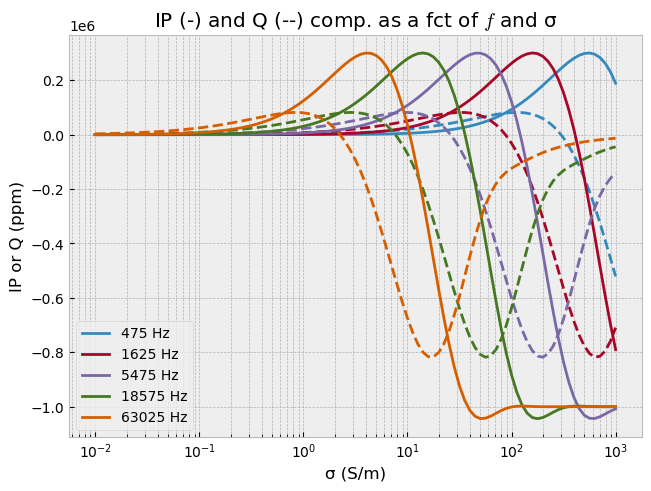

In [4]:
fig1, ax1 = plt.subplots(1, 1, constrained_layout=True)

for i, f in enumerate(freq):
    ax1.semilogx(conductivities, IP[:, i], f'C{i}-', label=f"{f} Hz")
    ax1.semilogx(conductivities, Q[:, i], f'C{i}--')

ax1.set_title('IP (-) and Q (--) comp. as a fct of $f$ and σ')
ax1.set_xlabel('σ (S/m)')
ax1.set_ylabel('IP or Q (ppm)')
ax1.legend()
ax1.grid('on', 'minor', 'both')

### Compute and plot apparent conductivity

$$
\sigma_\rm{app} = \frac{4Q}{\omega\mu_0 r^2}
$$

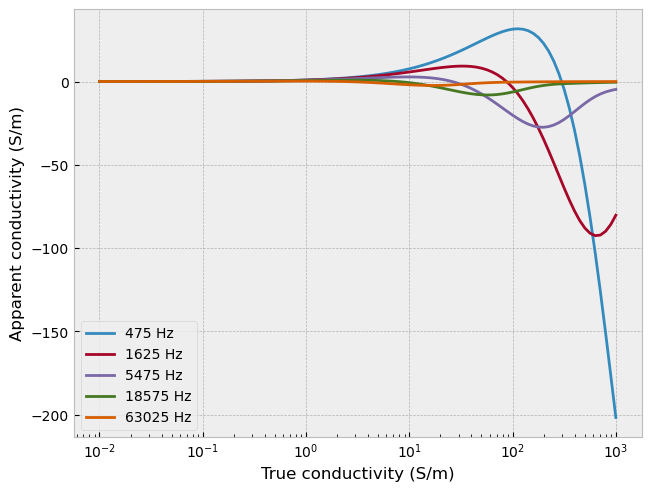

In [5]:
mu_0 = 4e-7*np.pi
omega = 2*np.pi*freq
app_cond = 4 * Q / 1e6 / (omega * mu_0 * coil_sep**2)

fig2, ax2 = plt.subplots(1, 1, constrained_layout=True)
ax2.plot(conductivities, app_cond, label=[f"{f} Hz" for f in freq])
ax2.set_xscale('log')
ax2.legend()
ax2.set_xlabel('True conductivity (S/m)')
ax2.set_ylabel('Apparent conductivity (S/m)');

### Angles alpha, tau, and phi btw Inphase and Quadrature phase

In [6]:
# Phase angle alpha
alpha = np.atan2(Q, IP) * 180 / np.pi

# Phase angle tau
tau = np.atan2(IP, Q) * 180 / np.pi

# Total phase angle phi
def unwrap(inp):
    """Unwraps a signal in the range of `(-180, 180]` along the 0th axis."""
    return np.unwrap(inp, axis=0, period=360)
    
def wrap(inp):
    """Wraps a signal in the range of  `(-180, 180]`."""
    return np.mod(inp + 180, 360) - 180
    
total = wrap(90 + unwrap(tau))

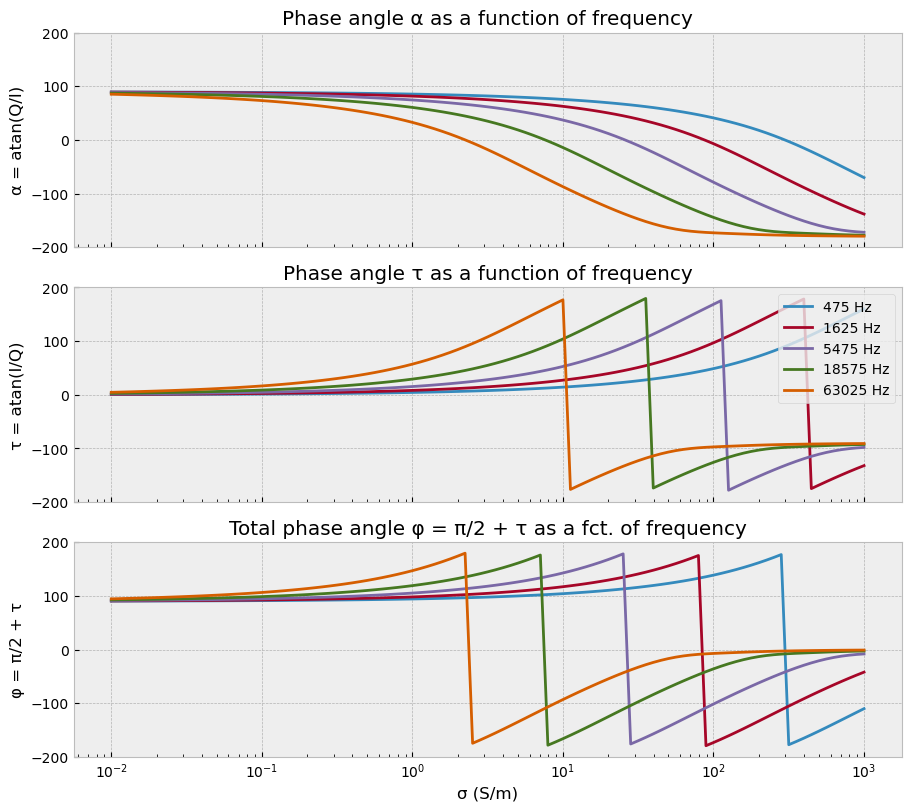

In [7]:
fig3, axs = plt.subplots(3, 1, figsize=(9, 8), sharex=True, sharey=True, constrained_layout=True)
ax3, ax4, ax5 = axs

# Phase angle alpha
ax3.semilogx(conductivities, alpha)
ax3.set_title('Phase angle α as a function of frequency')
ax3.set_ylabel('α = atan(Q/I)')

# Phase angle tau
ax4.semilogx(conductivities, tau, label=[f"{f} Hz" for f in freq])
ax4.set_title('Phase angle τ as a function of frequency')
ax4.set_ylabel('τ = atan(I/Q)')
ax4.legend()

# Total phase angle
ax5.semilogx(conductivities, total)
ax5.set_title('Total phase angle φ = π/2 + τ as a fct. of frequency')
ax5.set_xlabel('σ (S/m)')         
ax5.set_ylabel('φ = π/2 + τ')
ax5.set_ylim([-200, 200]);

In [8]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Mon Mar 10 21:15:58 2025 CET

                OS : Linux (Ubuntu 24.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 93.6 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC
  13.3.0]

             numpy : 2.0.2
             scipy : 1.14.1
             numba : 0.60.0
           empymod : 2.5.0
            libdlf : 0.3.0
           IPython : 8.31.0
        matplotlib : 3.10.0
--------------------------------------------------------------------------------